<a href="https://colab.research.google.com/github/juhumkwon/DeepLearning/blob/main/RL_01_05(Value_based).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

관측 차원: 4
행동 개수: 2
🚀 훈련 시작...
EP 010 | Return 30.0 | Epsilon 0.951
EP 020 | Return 11.0 | Epsilon 0.905
EP 030 | Return 11.0 | Epsilon 0.860
EP 040 | Return 19.0 | Epsilon 0.818
EP 050 | Return 40.0 | Epsilon 0.778
EP 060 | Return 32.0 | Epsilon 0.740
EP 070 | Return 28.0 | Epsilon 0.704
EP 080 | Return 20.0 | Epsilon 0.670
EP 090 | Return 29.0 | Epsilon 0.637
EP 100 | Return 30.0 | Epsilon 0.606
EP 110 | Return 67.0 | Epsilon 0.576
EP 120 | Return 68.0 | Epsilon 0.548
EP 130 | Return 22.0 | Epsilon 0.521
EP 140 | Return 43.0 | Epsilon 0.496
EP 150 | Return 45.0 | Epsilon 0.471
EP 160 | Return 98.0 | Epsilon 0.448
EP 170 | Return 65.0 | Epsilon 0.427
EP 180 | Return 16.0 | Epsilon 0.406
EP 190 | Return 54.0 | Epsilon 0.386
EP 200 | Return 30.0 | Epsilon 0.367
EP 210 | Return 36.0 | Epsilon 0.349
EP 220 | Return 19.0 | Epsilon 0.332
EP 230 | Return 19.0 | Epsilon 0.316
EP 240 | Return 18.0 | Epsilon 0.300
EP 250 | Return 114.0 | Epsilon 0.286
EP 260 | Return 28.0 | Epsilon 0.272
EP 270 |

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


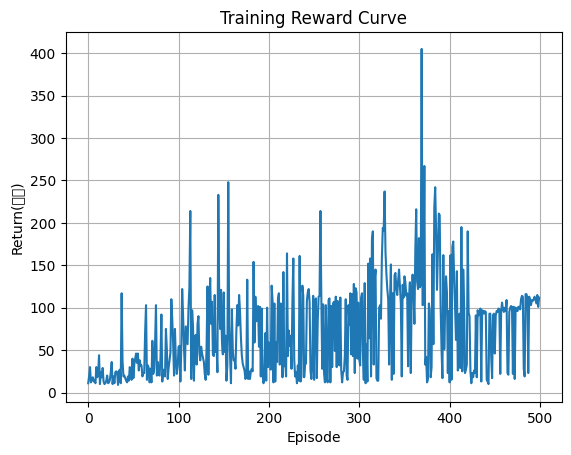

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/cartpole_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/cartpole_videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/cartpole_videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/cartpole_videos/rl-video-episode-0.mp4
🎬 비디오 파일: cartpole_videos/rl-video-episode-0.mp4


In [ ]:
# ================================================
# 🎥 CartPole DQN with Visualization (Video Playback)
# 강화학습(DQN) 기반 CartPole 문제 해결 + 비디오로 결과 확인
# ================================================

!pip install -q gymnasium[classic-control]==0.29.1

import numpy as np
import collections   # 경험 저장용 deque
import random        # 미니배치 랜덤 샘플링용
import matplotlib.pyplot as plt

import gymnasium as gym
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from gymnasium.wrappers import RecordVideo   # 비디오 저장을 위한 Wrapper
from IPython.display import Video, display   # Colab에서 영상 출력
import os


# =================================================
# 1) 강화학습 환경 생성 (CartPole)
# =================================================
# CartPole: 막대가 넘어지지 않도록 왼/오른쪽으로 카트를 움직이는 문제
env = gym.make("CartPole-v1")

# 상태(state)는 4차원 벡터
obs_dim = env.observation_space.shape[0]  # [카트 위치, 카트 속도, 막대 각도, 각속도]
# 행동(action) 공간은 2개 (왼쪽 / 오른쪽)
n_actions = env.action_space.n

print("관측 차원:", obs_dim)
print("행동 개수:", n_actions)


# =================================================
# 2) Q-Network 정의
# DQN: Q(s,a)를 신경망이 근사 → 행동을 선택하는 정책을 학습
# =================================================
def create_q_net():
    model = keras.Sequential([
        layers.Input(shape=(obs_dim,)),     # 입력: 현재 상태(4차원)
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(n_actions)             # 출력: 각 행동의 Q(s,a) 값 (2개)
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    return model

# 현재 정책을 학습하는 Q-Network
q_net = create_q_net()

# Target Network: Q-net의 복사본 → 학습 안정화 목적
target_q_net = create_q_net()
target_q_net.set_weights(q_net.get_weights())  # 초기에는 동일하게 설정


# =================================================
# 3) Replay Buffer 설정
# 과거 기록을 저장 → 샘플링 시 데이터 상관성 제거 (i.i.d. 보장)
# =================================================
Transition = collections.namedtuple("Transition", ["s","a","r","ns","d"])
buffer = collections.deque(maxlen=50000)  # 최근 5만 개 경험 저장


# =================================================
# 4) ε-greedy 탐색 정책
# ε 확률로 랜덤 행동 → 탐색(Exploration)
# 1-ε 확률로 Q값이 가장 큰 행동 → 활용(Exploitation)
# =================================================
def select_action(state, epsilon):
    # 무작위 탐색
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)

    # 모델 기반 행동 선택
    q = q_net(tf.convert_to_tensor(state[None, :], tf.float32))  # 배치 형식으로 변환
    return int(tf.argmax(q[0]))


# =================================================
# 5) Q-Network 학습 단계 (Mini-batch Update)
# Loss = (target Q - current Q)^2 최소화
# =================================================
@tf.function
def train_step(states, actions, rewards, next_states, dones):
    # numpy → Tensor 변환
    states_tf = tf.convert_to_tensor(states, tf.float32)
    next_states_tf = tf.convert_to_tensor(next_states, tf.float32)
    actions_tf = tf.convert_to_tensor(actions, tf.int32)
    rewards_tf = tf.convert_to_tensor(rewards, tf.float32)
    dones_tf = tf.convert_to_tensor(dones, tf.float32)

    # Target Network에서 다음 Q값 계산
    next_q = target_q_net(next_states_tf)
    max_next_q = tf.reduce_max(next_q, axis=1)  # 행동 중 최대 Q값

    # Bellman Equation 적용
    # target = r + γ * maxQ(s',·)  (단, 종료된 경우(next state 없음) γ 제외)
    target_values = rewards_tf + 0.99 * max_next_q * (1 - dones_tf)

    # 현재 Q-net 업데이트
    with tf.GradientTape() as tape:
        q_values = q_net(states_tf)          # 모든 행동 Q값 계산
        # 선택한 행동에 대한 Q(s,a)만 추출
        idx = tf.stack([tf.range(tf.shape(actions_tf)[0]), actions_tf], axis=1)
        chosen_q = tf.gather_nd(q_values, idx)

        # MSE Loss
        loss = tf.reduce_mean((target_values - chosen_q)**2)

    grads = tape.gradient(loss, q_net.trainable_variables)
    q_net.optimizer.apply_gradients(zip(grads, q_net.trainable_variables))


# =================================================
# 6) 학습 루프
# =================================================
returns = []
epsilon = 1.0  # 탐색률 100%에서 시작 → 점점 감소

print("🚀 훈련 시작...")
state, _ = env.reset()

# 학습 전 Replay Buffer warm-up (필수)
while len(buffer) < 1000:
    a = env.action_space.sample()
    ns, r, term, trunc, _ = env.step(a)
    buffer.append(Transition(state,a,r,ns,term or trunc))
    state = ns
    if term or trunc:
        state,_ = env.reset()

# 총 500 Episode 학습
for ep in range(1, 301):
    state,_ = env.reset()
    total = 0

    for t in range(500):
        a = select_action(state, epsilon)
        ns, r, term, trunc, _ = env.step(a)
        buffer.append(Transition(state,a,r,ns,term or trunc))
        state = ns
        total += r

        # 미니배치(64) 랜덤 샘플링
        batch = random.sample(buffer, 64)
        b_s = np.array([x.s for x in batch])
        b_a = np.array([x.a for x in batch])
        b_r = np.array([x.r for x in batch])
        b_ns = np.array([x.ns for x in batch])
        b_d = np.array([x.d for x in batch])

        train_step(b_s,b_a,b_r,b_ns,b_d)

        if term or trunc:
            break

    # 탐색률 감소 → 점점 정책을 따르게 함
    epsilon = max(0.01, epsilon * 0.995)
    returns.append(total)

    # Target Network는 가끔씩만 동기화 → 안정성 향상
    if ep % 10 == 0:
        target_q_net.set_weights(q_net.get_weights())
        print(f"EP {ep:03d} | Return {total:4.1f} | Epsilon {epsilon:.3f}")


# =================================================
# 7) 학습 리워드 시각화
# =================================================
plt.plot(returns)
plt.xlabel("Episode")
plt.ylabel("Return(점수)")
plt.title("Training Reward Curve")
plt.grid(True)
plt.show()


# =================================================
# 8) 학습 결과 비디오 녹화
# =================================================
video_folder = "cartpole_videos/"
os.makedirs(video_folder, exist_ok=True)

eval_env = RecordVideo(
    gym.make("CartPole-v1", render_mode="rgb_array"),
    video_folder,
    episode_trigger=lambda x: True   # 한 번만 녹화
)

state, _ = eval_env.reset()
done = False

while not done:
    q = q_net(tf.convert_to_tensor(state[None,:],tf.float32))
    action = int(tf.argmax(q[0]))  # 탐욕 정책(탐색 없음)
    ns, r, term, trunc, _ = eval_env.step(action)
    done = term or trunc
    state = ns

eval_env.close()

# 비디오 자동 출력
videos = sorted(os.listdir(video_folder))
last_video_path = os.path.join(video_folder, videos[-1])
print("🎬 비디오 파일:", last_video_path)
display(Video(last_video_path, embed=True))


In [ ]:
from collections import namedtuple

"""
collections.namedtuple()은 파이썬에서 필드 이름을 가진 가벼운 불변(immutable) 객체를 생성하는 함수입니다.
쉽게 말해:
튜플처럼 메모리를 적게 쓰면서,
클래스처럼 이름으로 항목에 접근할 수 있는 데이터 구조를 만든다!
"""

Transition = namedtuple("Transition", ["s", "a", "r", "ns", "d"])
t = Transition(s=[1,0], a=1, r=1.0, ns=[1,1], d=False)

print(t.r)  # 1.0
print(t[3]) # 1.0

1.0
[1, 1]


In [ ]:
Python의 기본 자료형(list, tuple, dict)만으로는 부족한 상황을 해결하기 위해
더 빠르고 효율적인 자료구조를 제공하기 때문입니다.

예:
✓ 큐(Queue)
✓ 스택(Stack)
✓ 카운터
✓ 불변 튜플
✓ 순서 유지 딕셔너리